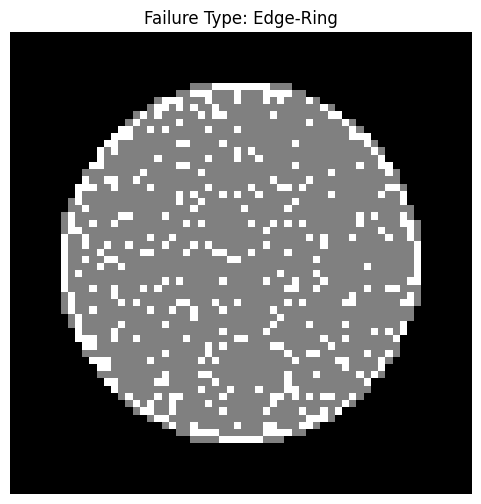

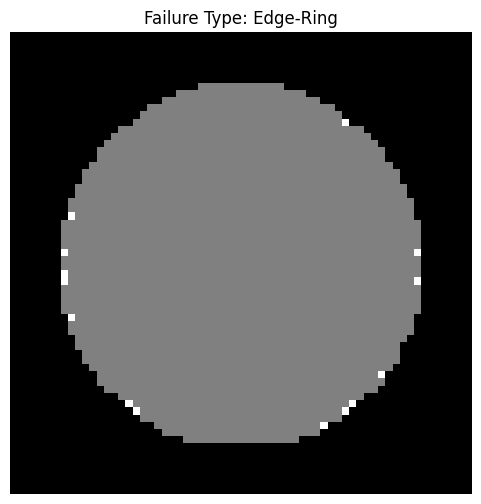

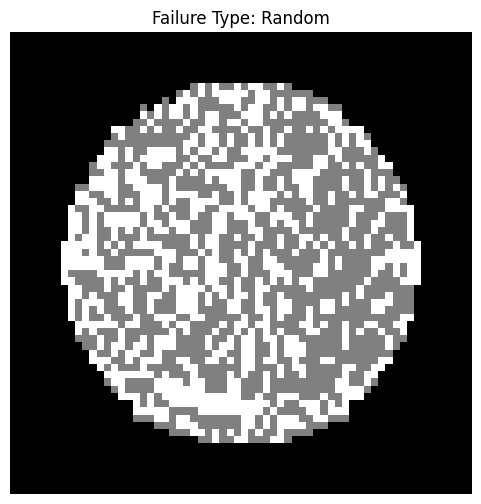

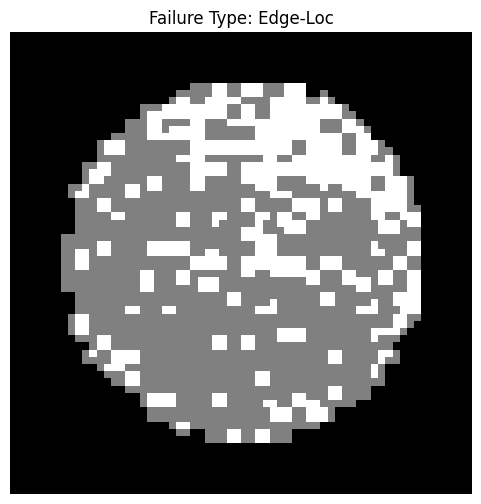

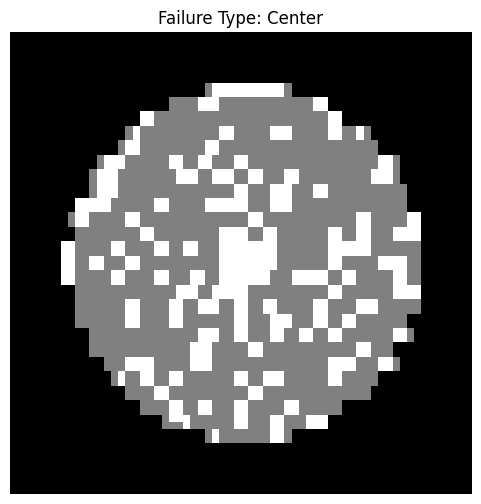

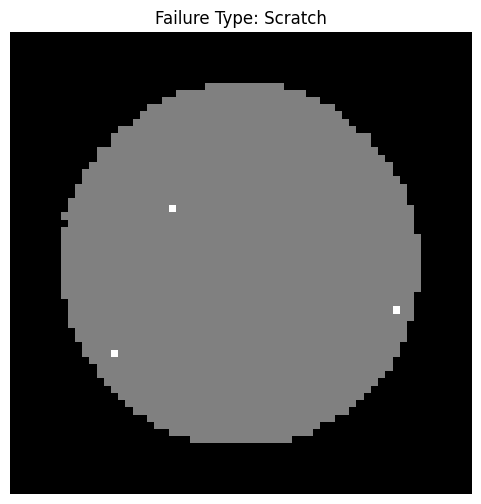

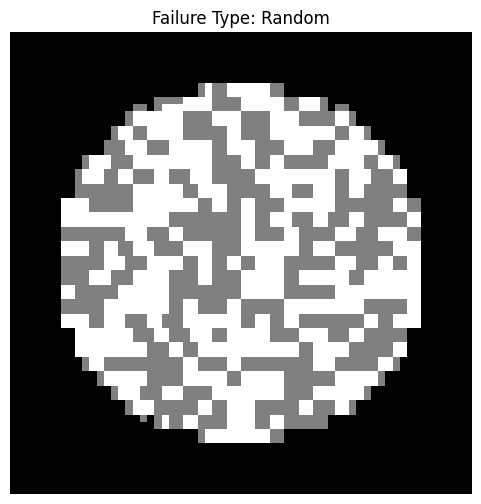

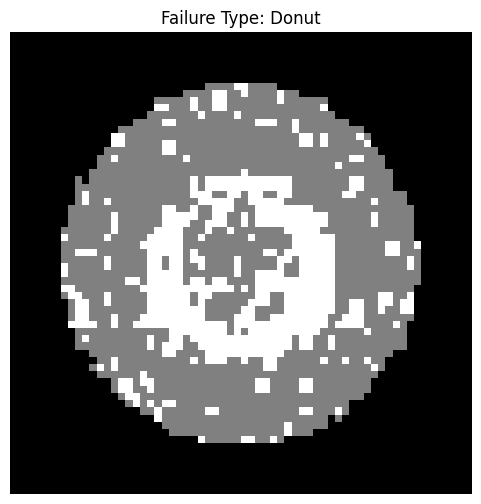

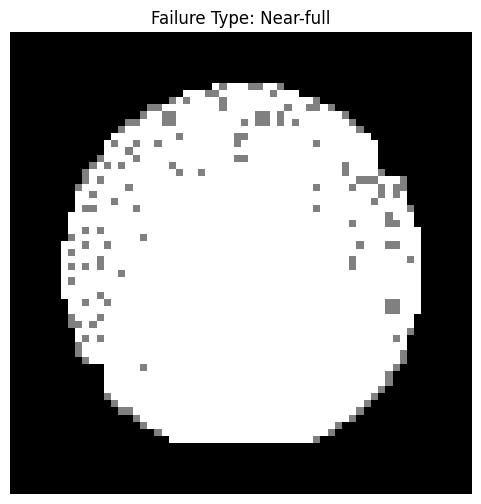

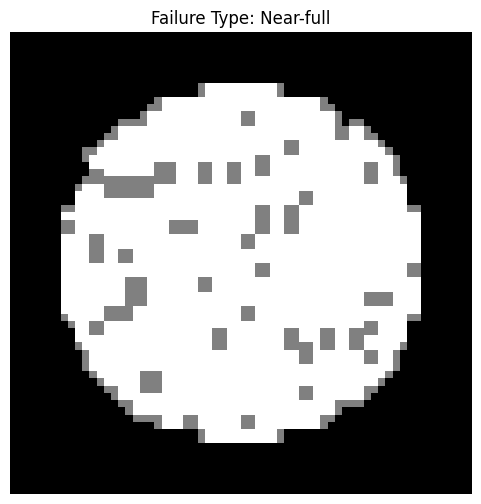

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import random
from PIL import Image

# Path to .pkl file
file_path = 'D:/Waffer Data/WM811K.pkl'

# Load the dataset
df = pd.read_pickle(file_path)

# Function to replace [0, 0] with 'Unknown'
def replace_zero_zero(x):
    if isinstance(x, (list, np.ndarray)) and np.array_equal(x, [0, 0]):
        return 'Unknown'
    return x

# Create a copy of the DataFrame
df_modified = df.copy()

# Apply the function to 'failureType' and 'trainTestLabel' columns
df_modified['failureType'] = df_modified['failureType'].apply(replace_zero_zero)
df_modified['trainTestLabel'] = df_modified['trainTestLabel'].apply(replace_zero_zero)

# Remove entries with 'No pattern' or 'Unknown'
df_modified_labelled = df_modified[
    ~df_modified['failureType'].isin(['none', 'Unknown'])
].reset_index(drop=True)

# Define dimension to demonstrate padding method
resize_dim = (50, 50)  # Resize to this dimension first
final_dim = (64, 64)   # Then pad to this final dimension

def resize_and_pad_wafer_map(wmap, resize_dim=(50,50), final_dim=(64,64)):
    # Convert numpy array to PIL Image
    img = Image.fromarray(wmap.astype('uint8'))
    # Resize the image to resize_dim
    img_resized = img.resize(resize_dim, Image.Resampling.LANCZOS)
    # Convert back to numpy array
    resized_arr = np.array(img_resized)
    
    # Now pad the resized image to final_dim
    h, w = resized_arr.shape
    final_h, final_w = final_dim

    # Calculate padding
    pad_top = (final_h - h) // 2
    pad_bottom = final_h - h - pad_top
    pad_left = (final_w - w) // 2
    pad_right = final_w - w - pad_left

    # Pad with zeros
    padded = np.pad(
        resized_arr, 
        ((pad_top, pad_bottom), (pad_left, pad_right)), 
        mode='constant', 
        constant_values=0
    )
    return padded

# Apply resizing and padding to wafer maps
df_modified_labelled['waferMap_processed'] = df_modified_labelled['waferMap'].apply(
    lambda x: resize_and_pad_wafer_map(x, resize_dim=resize_dim, final_dim=final_dim)
)

# Flatten the wafer maps after processing
df_modified_labelled['waferMap_flat'] = df_modified_labelled['waferMap_processed'].apply(lambda x: x.flatten())

# Reset index to ensure alignment
df_modified_labelled.reset_index(drop=True, inplace=True)

# Use 'trainTestLabel' column to split the data
# Assuming 'trainTestLabel' values are 'Training' and 'Test'
df_train = df_modified_labelled[df_modified_labelled['trainTestLabel'] == 'Training'].reset_index(drop=True)
df_test = df_modified_labelled[df_modified_labelled['trainTestLabel'] == 'Test'].reset_index(drop=True)

# Prepare data for oversampling on the training set
X_train = np.stack(df_train['waferMap_flat'].values).astype('float16')
y_train = df_train['failureType'].values

# Oversample the training data to balance the dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Prepare the test data without oversampling
X_test = np.stack(df_test['waferMap_flat'].values).astype('float32')
y_test = df_test['failureType'].values

# Encode labels using LabelEncoder fitted on training labels
encoder = LabelEncoder()
encoder.fit(y_train_resampled)  # Fit on training labels

y_train_enc = encoder.transform(y_train_resampled)
y_test_enc = encoder.transform(y_test)  # Apply the same encoder to test labels

num_classes = len(encoder.classes_)

# Create DataFrames with resampled training data and processed test data
df_train_resampled = pd.DataFrame({
    'waferMap_flat': list(X_train_resampled),
    'failureType_enc': y_train_enc
})

df_test_processed = pd.DataFrame({
    'waferMap_flat': list(X_test),
    'failureType_enc': y_test_enc
})

# Custom Dataset class
class WaferMapDataset(Dataset):
    def __init__(self, df, final_dim):
        self.X = np.stack(df['waferMap_flat'].values).astype('float32')
        self.y = df['failureType_enc'].values.astype('int64')
        self.num_samples = len(df)
        self.image_size = final_dim  # (64, 64)
       
    def __len__(self):
        return self.num_samples
       
    def __getitem__(self, idx):
        # Get wafer map and label
        wafer_map = self.X[idx]
        label = self.y[idx]
       
        # Convert wafer map to tensor and reshape to (1, 64, 64)
        wafer_map = torch.from_numpy(wafer_map)
        wafer_map = wafer_map.view(1, *self.image_size)
       
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
       
        return wafer_map, label

# Create Dataset instances
train_dataset = WaferMapDataset(df_train_resampled, final_dim)
test_dataset = WaferMapDataset(df_test_processed, final_dim)

# DataLoaders
batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Plotting 10 randomly selected processed wafer maps from the training set
random_indices = random.sample(range(len(df_train_resampled)), 10)

for idx in random_indices:
    wafer_map = df_train_resampled.iloc[idx]['waferMap_flat'].reshape(final_dim)
    label_enc = df_train_resampled.iloc[idx]['failureType_enc']
    label = encoder.inverse_transform([label_enc])[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(wafer_map, cmap='gray')
    plt.title(f'Failure Type: {label}')
    plt.axis('off')  # Hide axis
    plt.show()
